In [3]:
import torch
import torchvision
import torchvision.transforms as T
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Check if a GPU is available and if not, use a CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Function to preprocess the image
def preprocess(image_path):
    input_image = Image.open(image_path).convert("RGB")
    preprocess = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model
    return input_batch, input_image

# Function to post-process the output
def postprocess(output, original_image, person_class_id=15):
    output_predictions = output['out'][0].argmax(0)
    mask = output_predictions.byte().cpu().numpy()

    print(mask.shape)

    # Resize the mask to match the original image size
    mask_resized = cv2.resize(mask, (original_image.size[0], original_image.size[1]), interpolation=cv2.INTER_NEAREST)

    binary_mask = (mask == person_class_id).astype(np.uint8)

    return binary_mask

# Function to cut out the person from the background
def cutout_person(original_image, mask, person_class_id=15):
    # Create a binary mask where the person is segmented
    # binary_mask = (mask == person_class_id).astype(np.uint8)

    # Apply the binary mask to the original image to isolate the person
    person_cutout = cv2.bitwise_and(np.array(original_image), np.array(original_image), mask=mask)

    return person_cutout

# Function to process and visualize an image
def process_and_visualize(image_path, model):
    # Load and preprocess the image
    input_batch, original_image = preprocess(image_path)

    # Check if a GPU is available and if not, use a CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    input_batch = input_batch.to(device)

    # Run the segmentation
    with torch.no_grad():
        output = model(input_batch)

    # Post-process the output
    mask = postprocess(output, original_image)

    # Cut out the person from the background
    person_cutout = cutout_person(original_image, mask)

    return original_image, mask, person_cutout

/Users/sebastiandaws/miniconda3/envs/dsml_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastiandaws/miniconda3/envs/dsml_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(1792, 1792)
(1792, 1792)


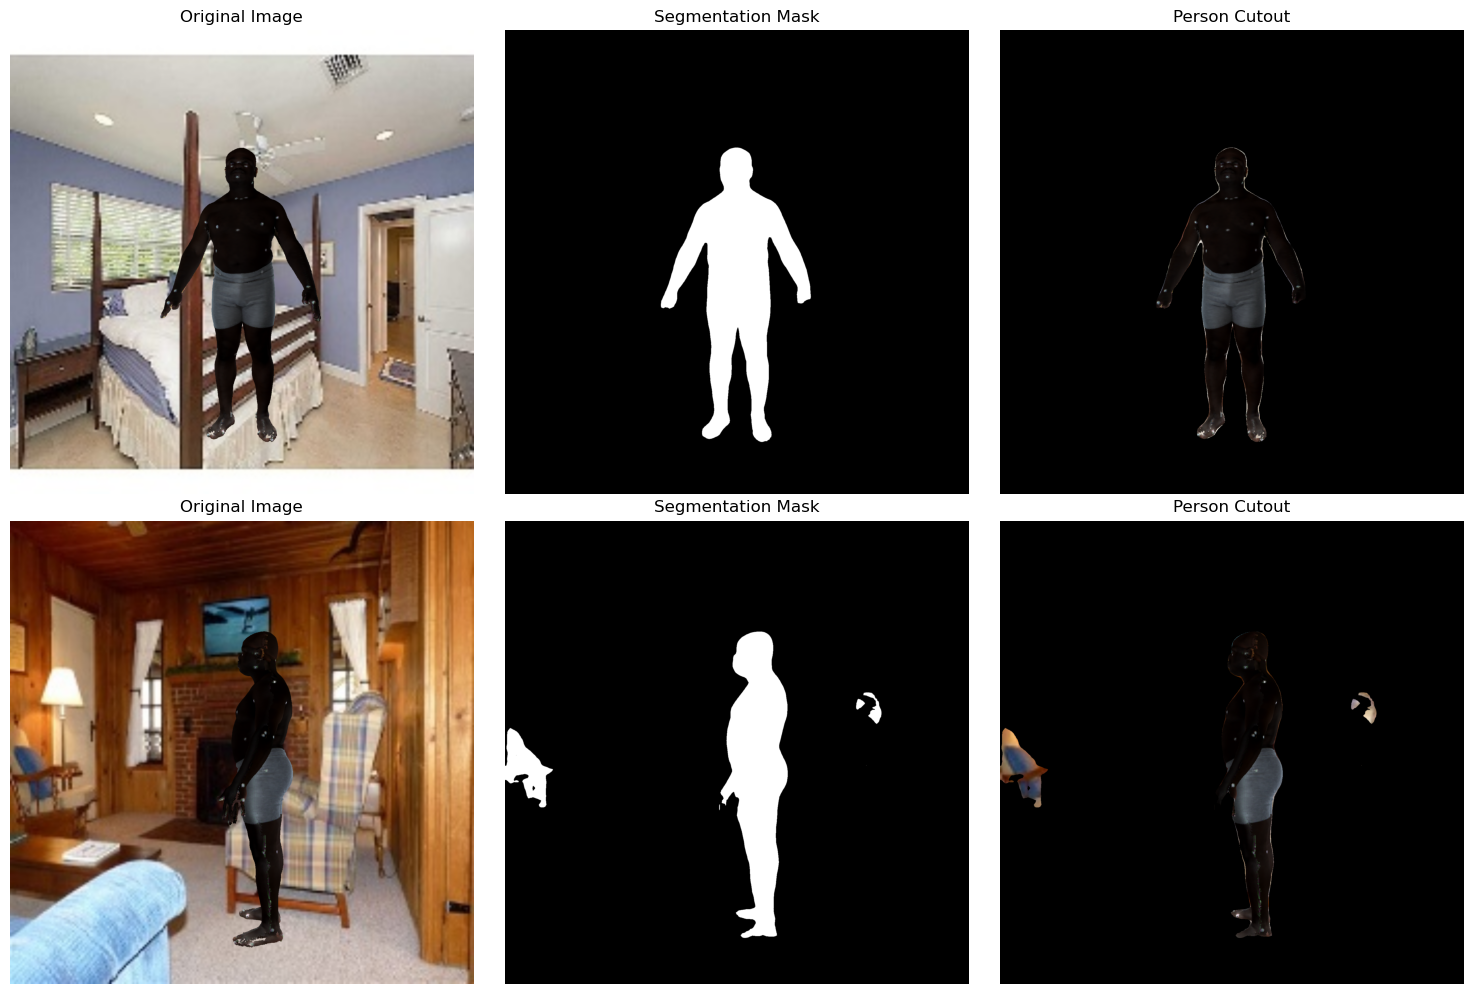

In [5]:
# Load the pre-trained DeepLabV3 model
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

# List of image paths
image_paths = [
    "CAESAR/output_dataset/images/csr0028a_front_view.png", 
    "CAESAR/output_dataset/images/csr0028a_side_view.png"
    ]

# Process and visualize each image
fig, axs = plt.subplots(len(image_paths), 3, figsize=(15, 10))

for idx, image_path in enumerate(image_paths):
    original_image, mask, person_cutout = process_and_visualize(image_path, model)

    # Plot the original image
    axs[idx, 0].imshow(original_image)
    axs[idx, 0].set_title("Original Image")
    axs[idx, 0].axis('off')

    # Plot the segmentation mask
    axs[idx, 1].imshow(mask, cmap='gray')
    axs[idx, 1].set_title("Segmentation Mask")
    axs[idx, 1].axis('off')

    # Plot the cutout image
    axs[idx, 2].imshow(person_cutout)
    axs[idx, 2].set_title("Person Cutout")
    axs[idx, 2].axis('off')

plt.tight_layout()
plt.show()

In [24]:
%run load_data.py

4768
torch.Size([3, 1792, 1792]) torch.Size([1, 1792, 1792])


/Users/sebastiandaws/miniconda3/envs/dsml_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastiandaws/miniconda3/envs/dsml_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


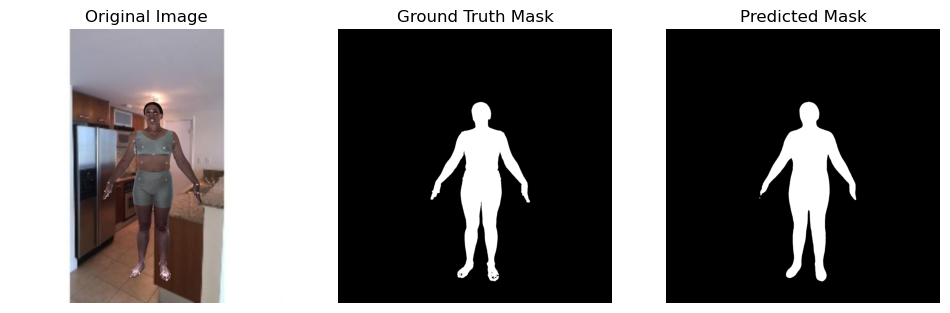

TypeError: unsupported format string passed to NoneType.__format__

In [1]:
%run test_deeplabv3.py